In [1]:
%load_ext autoreload
%autoreload 2

# Maintenant qu'il est bien bugfixé je veux voir qu'il fonctionne

In [2]:
import numpy as np
import Spiking_LGN as SpiLGN
import MotionClouds as mc
import matplotlib.pyplot as plt

MC shape (64, 64, 128)


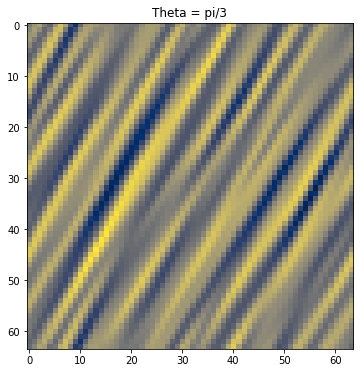

In [3]:
# (64x64)x128 frames @ 24 FPS = 5.2s stimuli
fx, fy, ft = mc.get_grids(64, 64, 128)

envelope = mc.envelope_gabor(fx, fy, ft,
                             V_X=1., V_Y=0., B_V=.1,
                             sf_0=.15, B_sf=.1,
                             theta=np.pi/3, B_theta=np.pi/50, alpha=1.)

movie = mc.random_cloud(envelope)
movie = mc.rectif(movie)

print('MC shape', movie.shape)

import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.imshow(movie[:,:,4], cmap = plt.cm.cividis)
plt.title('Theta = pi/3')
plt.show()

In [4]:
# then we run it into the method, careful here N_theta = 4
output_currents = SpiLGN.input_to_currents(video=movie, FPS=24, total_time=1000,
                                           distrib_size=10, safeguard_offset=20, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           off_gain = .5, #this is where we're testing
                                           n_jobs=-1, backend='loky', mt_verbose=10)

Video shape (64, 64, 128)
Frames per second: 24
Frame duration at 24 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)
Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.8min remaining:   55.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  4.2min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  6.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.2min finished


In [5]:
print('Output shape', np.asarray(output_currents).shape)
print('=(Thetas, Gabors, ON/OFF)')

Output shape (12, 16, 2)
=(Thetas, Gabors, ON/OFF)


In [6]:
#Now we save the currents, in a numpy compressed array to save space (2.5x less size)
#tradeoff : saving twice as slow
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

# Test 1 : La visualisation de courants avec le super plotter
# OK

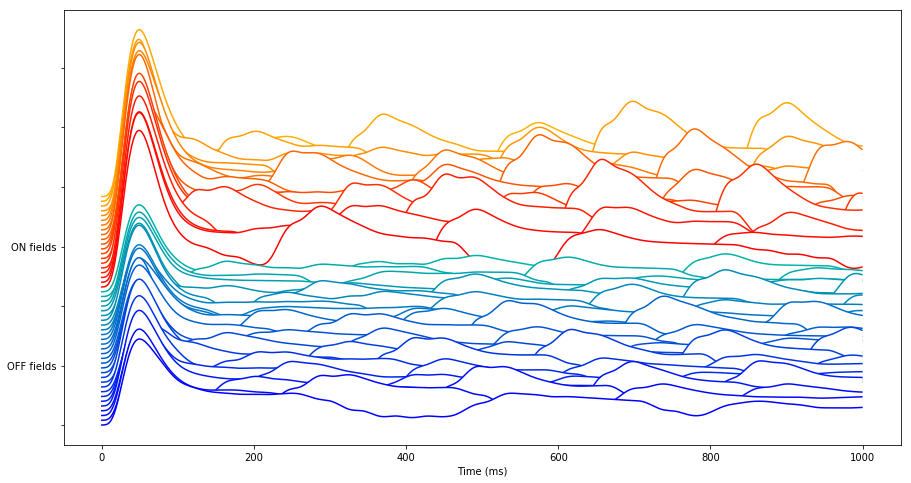

In [7]:
#We show the second Theta (here 2*pi/12 here) and third gabor (i.e. simple cell)
theta_display = 1
gabor_display = 3
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]

chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('white')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 25

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
#plt.savefig('./figs/2018_11_08_Script_output_white.pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

# Test 2 : La comparaison de niveau pour theta orthogonaux et theta parallèles
On veut parallèle > orthogonal, logiquement

# PAS OK, mais c'est peut être une question de synchronie de courant, qu'on voit pas la
# Mais c'est logique, la selectivité à l'orientation s'implemente dans la convergence LGN V1 pas dans le LGN

Orientation du MC (°) 59.99999999999999
Orientation du gabor de gauche 135.0
Orientation du gabor de droite 59.99999999999999


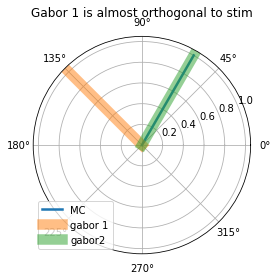

In [8]:
import matplotlib.pyplot as plt
import numpy as np
print('Orientation du MC (°)', np.pi/3*180/np.pi)
print('Orientation du gabor de gauche', 9*(np.pi/12)*180/np.pi)
print('Orientation du gabor de droite', 4*(np.pi/12)*180/np.pi)


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='polar')

theta = (np.pi/3, np.pi/3)
R = [0, 1]
ax.plot(theta, R, lw=2.5, label='MC')

theta = (9*(np.pi/12), 9*(np.pi/12))
R = [0, 1]
ax.plot(theta, R, lw=10.5, alpha=.5, label='gabor 1')

theta = (4*(np.pi/12), 4*(np.pi/12))
R = [0, 1]
ax.plot(theta, R, lw=10.5, alpha=.5, label='gabor2')

ax.set_title("Gabor 1 is almost orthogonal to stim", va='bottom')
plt.legend()
plt.show()

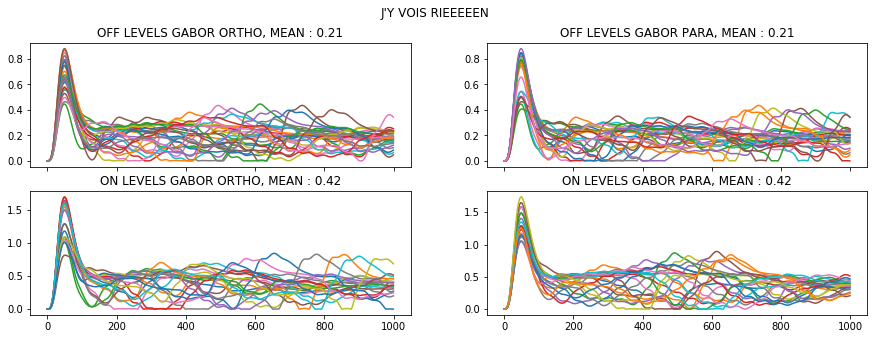

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,5))

theta_display = 11
gabor_display = 5 #au pif, on s'en fou de lui
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]
for off in off_st_levels :
    axs[0][0].plot(off)
axs[0][0].set_title('OFF LEVELS GABOR ORTHO, MEAN : %.2f' % off_st_levels.mean())
axs[0][0].set_xticklabels([])
for on in on_st_levels:
    axs[1][0].plot(on)
axs[1][0].set_title('ON LEVELS GABOR ORTHO, MEAN : %.2f' % on_st_levels.mean())

theta_display = 4
gabor_display = 5 #au pif, on s'en fou de lui
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]
for off in off_st_levels :
    axs[0][1].plot(off)
axs[0][1].set_title('OFF LEVELS GABOR PARA, MEAN : %.2f' % off_st_levels.mean())
axs[0][1].set_xticklabels([])
for on in on_st_levels:
    axs[1][1].plot(on)
axs[1][1].set_title('ON LEVELS GABOR PARA, MEAN : %.2f' % on_st_levels.mean())

plt.suptitle("J'Y VOIS RIEEEEEN")
plt.show()

# Test 3 : Tuning curve d'entrée du ring

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


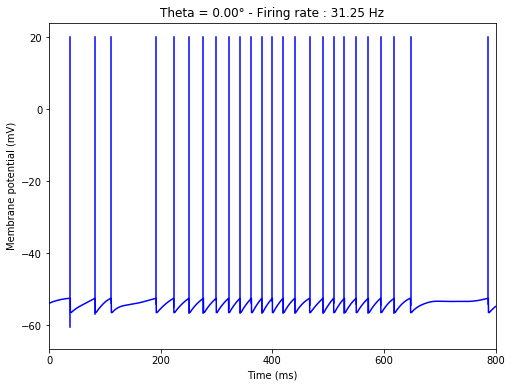

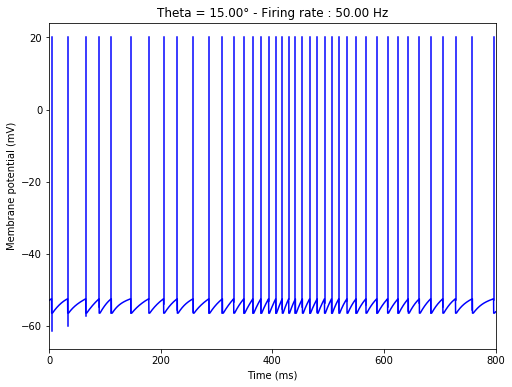

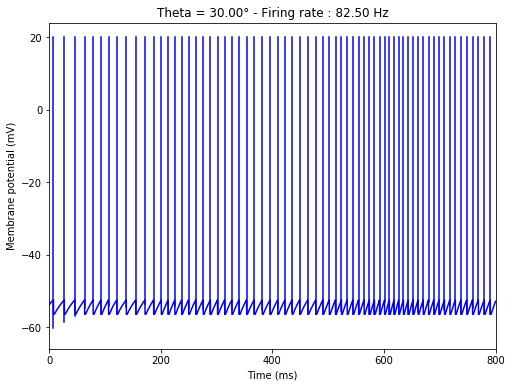

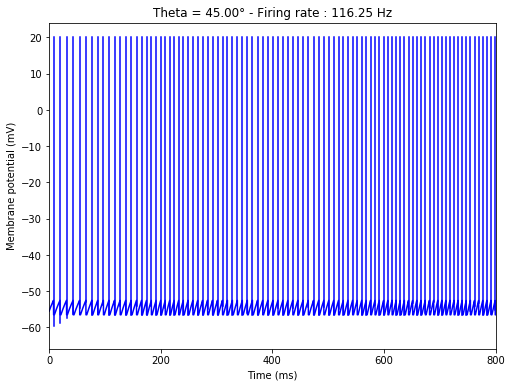

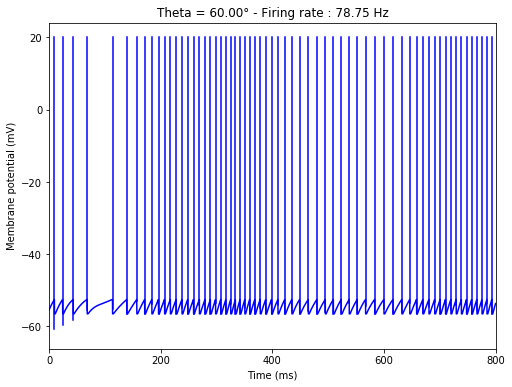

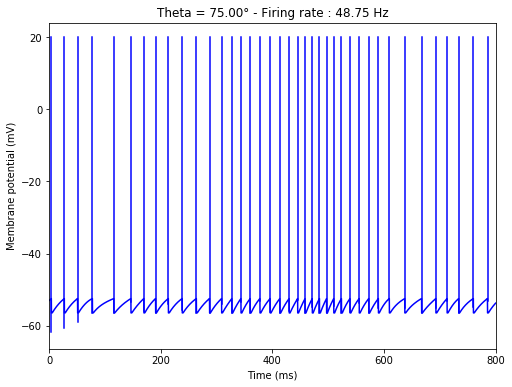

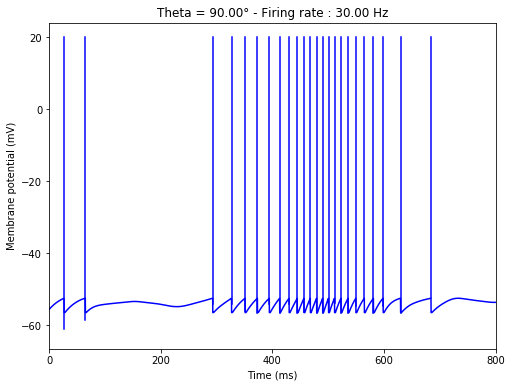

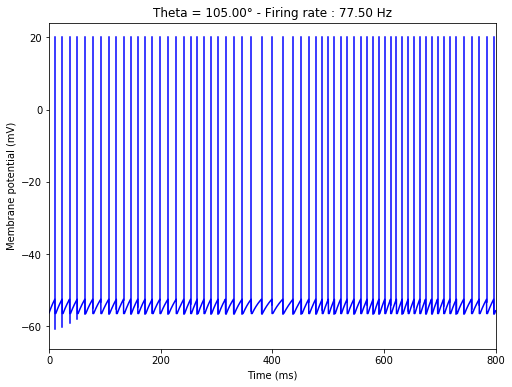

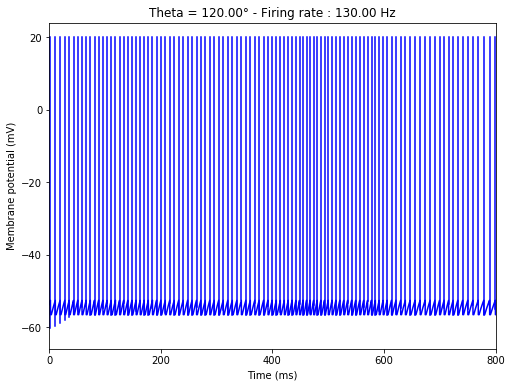

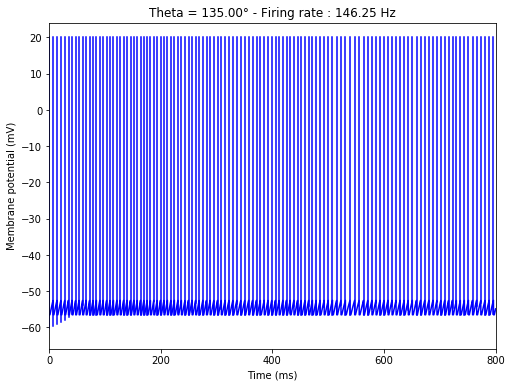

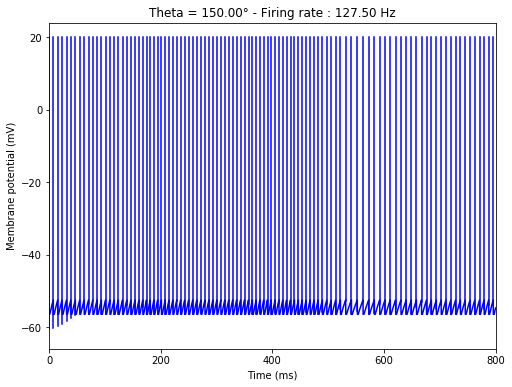

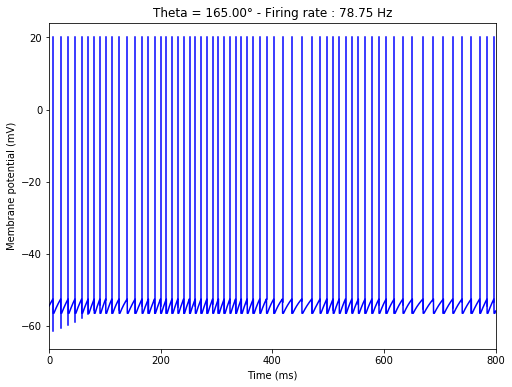

In [10]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }
load_arr = output_currents
gain = .1
injection_sampling_rate = 1
total_time = len(load_arr[0][0][0][0])

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

fr_list = []
#we'll loop through 12 thetas but keep the same cell location (gabor : 0)
for theta,_ in enumerate(load_arr) :
    running_theta = theta*(np.pi/12)*180/np.pi
    
    current_levels = load_arr[theta][10] #gabor 6
    
    ##############
    # Simulation #
    ##############
    sim.setup(timestep=0.1, threads = 8)

    post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


    #injecting all ON cells current
    for inputs in range(len(current_levels[0])):

        current_level = current_levels[0][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*gain)
        current_input.inject_into(post)
        current_input.record()

    #injecting all OFF cells current
    for inputs in range(len(current_levels[1])):

        current_level = current_levels[1][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*(-gain/1.8))
        current_input.inject_into(post)
        current_input.record()

    post.record(['spikes', 'v'])

    sim.run(total_time)
    sim.end()

    #PLOTTING and DATA
    post_v = post.get_data().segments[0]
    sig = post_v.analogsignals[0]
    
    plt.figure(figsize = (8,6))
    plt.plot(sig, color = 'b')

    for spikes in np.asarray(post_v.spiketrains[0]):
        plt.plot( [ spikes*10,spikes*10 ] , [sig[int(spikes)] , 20], color = 'b')
        #plt.axvline(spikes*10, ymin = .15, ymax = .9)

    beg = 200 # we have an initialisation firing that causes problems so we remove the first 200 ms

    non_init_times = post_v.spiketrains[0].times > beg
    non_init_spikes = np.asarray(post_v.spiketrains[0])*non_init_times
    non_init_spikes = np.nonzero(non_init_spikes)[0]
    
    fr = non_init_spikes.shape[0]*1000/800
    plt.title('Theta = %.2f° - Firing rate : %.2f Hz' % (running_theta,fr))
    fr_list.append(fr)
              
    plt.xticks([2000, 4000, 6000, 8000, 10000],[0, 200, 400, 600, 800])
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane potential (mV)')

    plt.xlim(beg*10,10000) 

    plt.show()
    plt.pause(.1)


In [11]:
from lmfit.models import GaussianModel
x = np.linspace(0, len(fr_list), len(fr_list))
y = np.asarray(fr_list)

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
#print(out.fit_report(min_correl=0.25))

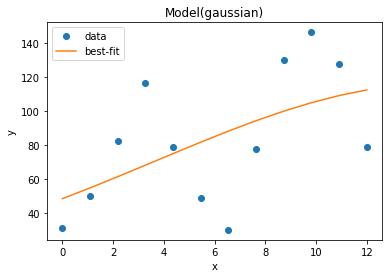

In [12]:
out.plot_fit()

# Test 4 : La forme des gabors
Tiens tiens ça serait pas symétrique ?

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

total_time = 1000
FPS = 24.
movie.shape

(64, 64, 128)

In [14]:
video = movie # l'art du cinéma
frame_duration = int(total_time/FPS)
stimuli = []
for ms in range(int(total_time/frame_duration)):
    for same_frame in range(frame_duration):
        stimuli.append(video[:, :, ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])
if stimuli[0][30, 30] != stimuli[frame_duration+1][30, 30] :
    print('FPS difference sanity check passed !\n')
if stimuli[456][30, 30] == stimuli[457][30, 30] :
    print('FPS identity sanity check passed !\n')

#print(np.swapaxes(np.asarray(stimuli).T, 0,1).shape)
stimuli = np.swapaxes(np.asarray(stimuli).T, 0, 1)
print('Stimuli shape',stimuli.shape)

FPS difference sanity check passed !

FPS identity sanity check passed !

Stimuli shape (64, 64, 1000)


Centers coordinates shape (2, 16)


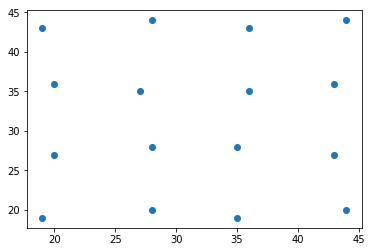

In [15]:
distrib_size = 10
safeguard_offset = 2 * distrib_size
random_shift = 1

centers_coordinates = SpiLGN.generate_centers_coordinates(
        distrib_size, safeguard_offset, random_shift, stimuli)

print('Centers coordinates shape', centers_coordinates.shape)

plt.scatter(centers_coordinates[0], centers_coordinates[1])

In [16]:
np.linspace(0, np.pi, 12, endpoint = False)

array([0.        , 0.26179939, 0.52359878, 0.78539816, 1.04719755,
       1.30899694, 1.57079633, 1.83259571, 2.0943951 , 2.35619449,
       2.61799388, 2.87979327])

In [17]:
gabor_coordinates = []

gabor_params = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                         'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                         'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                         'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                         'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                         'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                         'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                         'white_recompute': False, 'white_steepness': 4.0}
N_theta = 12 #simplifying it
B_theta = 15
sf_0=.05,
B_sf=.5
on_thresh=0
off_thresh=0
grid_res = 3

                            
#no multithreading to have clearer view
for theta in tqdm(np.linspace(0, np.pi, N_theta, endpoint = False)):
    gabor_coordinate = SpiLGN.generate_gabors_coordinates(theta,
                                      params=gabor_params,
                                      N_X=stimuli.shape[1], N_Y=stimuli.shape[0],
                                      centers_coordinates=centers_coordinates,
                                      B_theta=B_theta, sf_0=sf_0, B_sf=B_sf,
                                      on_thresh=on_thresh, off_thresh=off_thresh,
                                      distrib_size=distrib_size, grid_res=grid_res)
                                     
    gabor_coordinates.append(gabor_coordinate)
    
gabor_coordinates = np.asarray(gabor_coordinates)

  0%|          | 0/12 [00:00<?, ?it/s]

Thread started !
Filter grid shape (49, 2) 



  8%|▊         | 1/12 [00:28<05:12, 28.40s/it]

Thread started !
Filter grid shape (49, 2) 



 17%|█▋        | 2/12 [00:50<04:26, 26.63s/it]

Thread started !
Filter grid shape (49, 2) 



 25%|██▌       | 3/12 [01:17<04:00, 26.69s/it]

Thread started !
Filter grid shape (49, 2) 



 33%|███▎      | 4/12 [01:40<03:24, 25.62s/it]

Thread started !
Filter grid shape (49, 2) 



 42%|████▏     | 5/12 [02:03<02:53, 24.79s/it]

Thread started !
Filter grid shape (49, 2) 



 50%|█████     | 6/12 [02:26<02:25, 24.23s/it]

Thread started !
Filter grid shape (49, 2) 



 58%|█████▊    | 7/12 [02:53<02:05, 25.12s/it]

Thread started !
Filter grid shape (49, 2) 



 67%|██████▋   | 8/12 [03:19<01:40, 25.22s/it]

Thread started !
Filter grid shape (49, 2) 



 75%|███████▌  | 9/12 [03:42<01:13, 24.50s/it]

Thread started !
Filter grid shape (49, 2) 



 83%|████████▎ | 10/12 [04:04<00:47, 23.78s/it]

Thread started !
Filter grid shape (49, 2) 



 92%|█████████▏| 11/12 [04:29<00:24, 24.09s/it]

Thread started !
Filter grid shape (49, 2) 



100%|██████████| 12/12 [04:54<00:00, 24.42s/it]


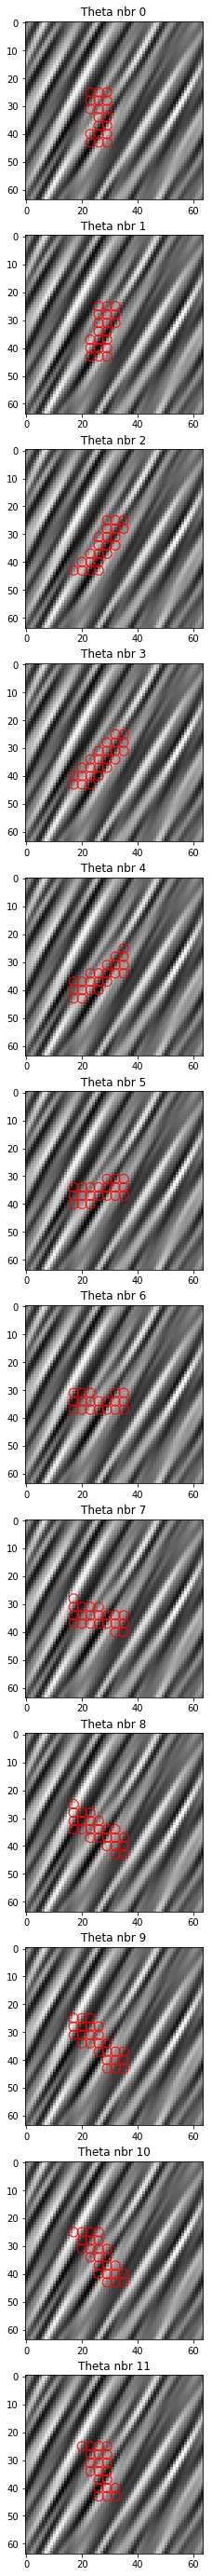

In [18]:
fig, axs = plt.subplots(gabor_coordinates.shape[0], figsize = (20,50))

for it, theta in enumerate(gabor_coordinates) :
    gab = 6
    filters_in_gabor = theta[gab][0]
    off_filters_in_gabor = theta[gab][1]
    for filt in filters_in_gabor :
        axs[it].scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'red')


    axs[it].set_title('Theta nbr '+ str(it))
    axs[it].imshow(stimuli[:,:,0], cmap = plt.cm.binary)